In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.2 MB/s eta 0:00:00


In [2]:
import math
from transformers import GPT2Tokenizer, TFGPT2Model
import tensorflow as tf
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
     

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')    

Mounted at /content/gdrive


In [4]:
print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.12.0
Running on TPU  grpc://10.39.37.226:8470


REPLICAS:  8


In [5]:
df = pd.read_pickle('/content/gdrive/MyDrive/cleantrain.pkl')

In [6]:
#df = df.sample(120000,random_state=30)

In [7]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [8]:
X_train

1699297    nfl player are covered by a union contract whi...
396213     wow i dont have to wonder what your credibilit...
1146983    im non status metis do i owe half a much a you...
65100      translation no i am not going to spend a lot o...
801540     a great article about an important and problem...
                                 ...                        
1492980    the laity wait in vain very seldom do those in...
1021165    pathetic there is clearly a pattern of intenti...
590154                   thats not detroit in the background
428933     according to the official navy department libr...
1498925    hi john im getting close enough to retirement ...
Name: clean_text, Length: 270730, dtype: object

In [9]:
MAX_LENGTH = math.ceil((X_train.apply(lambda x: len(str(x).split())).mean()))+2
MAX_LENGTH

52

In [10]:
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

# this will download and initialize the pre trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",
    pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN,
    max_length=MAX_LENGTH,
    is_split_into_words=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
X_train = [str(ex) + EOS_TOKEN for ex in X_train]
X_test = [str(ex) + EOS_TOKEN for ex in X_test]

In [12]:
X_train_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_test_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]

X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
X_train_in[0]

<tf.Tensor: shape=(52,), dtype=int32, numpy=
array([   77,  2704,  2137,   389,  5017,   416,   257,  6441,  2775,
         543,  4179,   644,  9749,   460,   466,  1312,  4481,   319,
         428,  8057, 50256, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257], dtype=int32)>

In [14]:
X_train_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_test_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]

X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

In [15]:
pickle_train_inp_path='/content/gdrive/MyDrive/GPT2_inp.pkl'
pickle_train_mask_path='/content/gdrive/MyDrive/GPT2_mask.pkl'
pickle_test_inp_path='/content/gdrive/MyDrive/GPT2_test_inp.pkl'
pickle_test_mask_path='/content/gdrive/MyDrive/GPT2_test_mask.pkl'

In [16]:
pickle.dump(X_train_in, open(pickle_train_inp_path, 'wb'))
pickle.dump(X_train_mask, open(pickle_train_mask_path, 'wb'))
pickle.dump(X_test_in, open(pickle_test_inp_path, 'wb'))
pickle.dump(X_test_mask, open(pickle_test_mask_path, 'wb'))

In [ ]:
print('Loading the saved pickle files..')

X_train_in=pickle.load(open(pickle_train_inp_path, 'rb'))
X_train_mask=pickle.load(open(pickle_test_inp_path, 'rb'))
X_test_in=pickle.load(open(pickle_train_inp_path, 'rb'))
X_test_mask=pickle.load(open(pickle_test_mask_path, 'rb'))



Loading the saved pickle files..


In [17]:
model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
model.training = True

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [18]:
with strategy.scope():
  model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
  model.training = True
  model.resize_token_embeddings(len(tokenizer))
  for layer in model.layers:
    layer.trainable = False
  model.summary()
  input = tf.keras.layers.Input(shape=(None,), dtype='int32')
  mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
  x = model(input, attention_mask=mask)
  #x = x.last_hidden_state[:, -1]
  x = tf.reduce_mean(x.last_hidden_state, axis=1)
  x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  clf = tf.keras.Model([input, mask], output)
  clf.summary()
  base_learning_rate = 0.00005
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
  loss=tf.keras.losses.BinaryCrossentropy()


  clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Model: "tfgpt2_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124440576 
 r)                                                              
                                                                 
Total params: 163,038,720
Trainable params: 38,598,144
Non-trainable params: 124,440,576
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []             

Model: "tfgpt2_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124440576 
 r)                                                              
                                                                 
Total params: 163,038,720
Trainable params: 38,598,144
Non-trainable params: 124,440,576
_________________________________________________________________


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tfgpt2_model_2 (TFGPT2Model)   TFBaseModelOutputWi  124440576   ['input_5[0][0]',                
                                thPastAndCrossAtten               'input_6[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, None, 7                                         

In [ ]:
base_learning_rate = 0.00005
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
loss=tf.keras.losses.BinaryCrossentropy()

clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [19]:
callbacks = tf.keras.callbacks.EarlyStopping(
        monitor="accuracy", verbose=1, patience=1, restore_best_weights=True)

In [20]:
y_train_in = tf.constant(y_train, dtype=tf.int32)
y_test_in = tf.constant(y_test, dtype=tf.int32)

In [21]:
#tf.config.experimental_run_functions_eagerly(True)

In [22]:
history = clf.fit([X_train_in, X_train_mask], y_train_in, epochs=4, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/4
3385/3385 [==============================] - 215s 54ms/step - loss: 2.9774 - accuracy: 0.5769 - val_loss: 0.7066 - val_accuracy: 0.6551
Epoch 2/4
3385/3385 [==============================] - 160s 47ms/step - loss: 0.6191 - accuracy: 0.7054 - val_loss: 0.6663 - val_accuracy: 0.7657
Epoch 3/4
3385/3385 [==============================] - 160s 47ms/step - loss: 0.5049 - accuracy: 0.7802 - val_loss: 0.5868 - val_accuracy: 0.8034
Epoch 4/4
3385/3385 [==============================] - 160s 47ms/step - loss: 0.4576 - accuracy: 0.8047 - val_loss: 0.5493 - val_accuracy: 0.8168


In [23]:
clf.evaluate([X_test_in, X_test_mask], y_test_in)

2821/2821 [==============================] - 56s 19ms/step - loss: 0.5433 - accuracy: 0.8162


[0.5433111190795898, 0.8162204623222351]

In [24]:
clf.training = False
y_pred = clf.predict([X_test_in, X_test_mask])

2821/2821 [==============================] - 48s 16ms/step


In [25]:
pred_labels = np.where(y_pred > 0.5, 1, 0)
pred_labels

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [28]:
pred_labels=pred_labels.flatten()

In [31]:
pred_labels

array([0, 0, 0, ..., 1, 1, 0])

In [32]:
print(classification_report(y_test_in, pred_labels))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     54160
           1       0.83      0.68      0.75     36084

    accuracy                           0.82     90244
   macro avg       0.82      0.79      0.80     90244
weighted avg       0.82      0.82      0.81     90244



<ipython-input-33-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


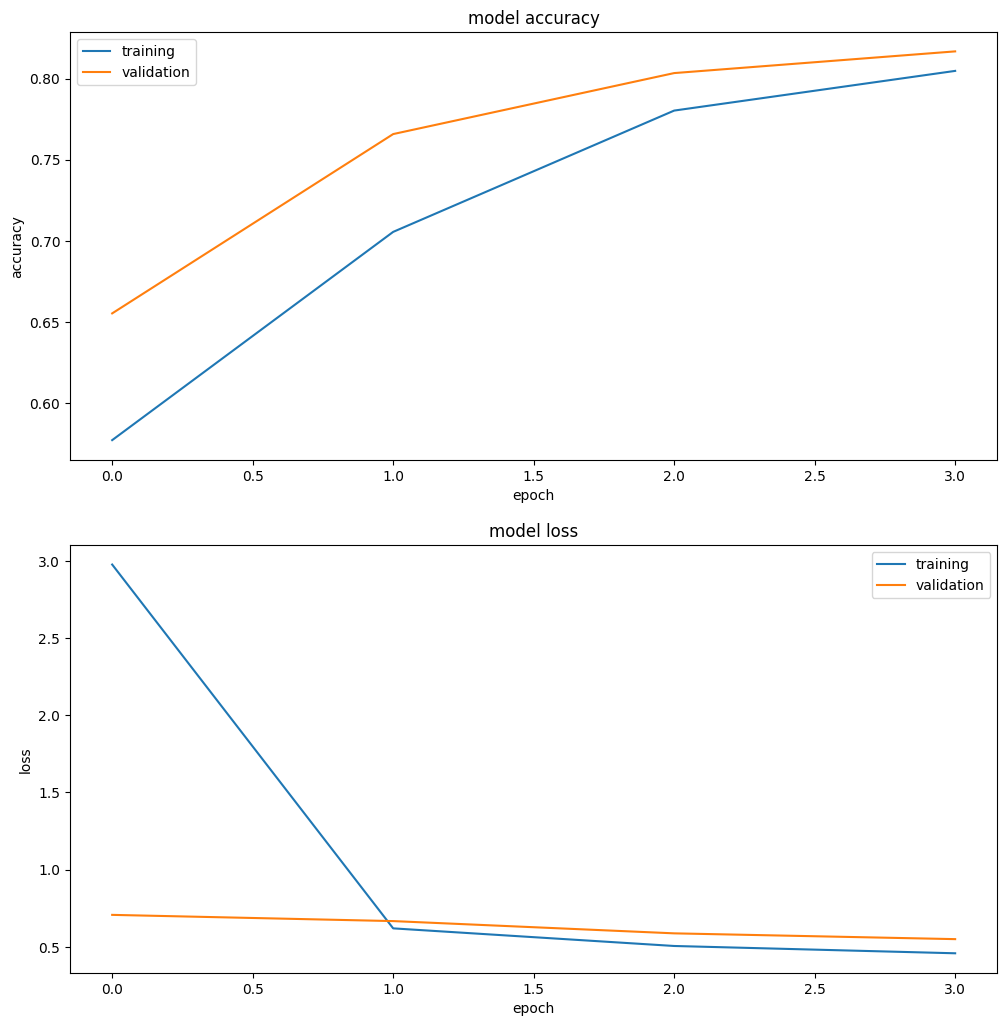

In [33]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

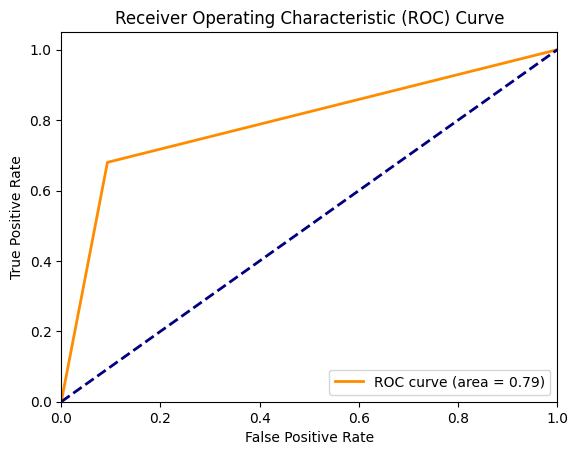

In [35]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
fpr, tpr, thresholds = roc_curve(y_test_in, pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")